In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Dropout
from tqdm import tqdm
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [2]:
tf.config.list_physical_devices('GPU')

2022-04-13 09:22:24.382948: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-13 09:22:24.393680: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-13 09:22:24.394389: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
df = pd.read_csv("./data/preprocessed_data.csv")
df


,time_of_day,time_of_week,time_of_year,hydro,micro,thermal,wind,total,sys_reg,flow,y_prev,y
0,14,2,1,1591.839,141.928,11.5,74.428,1819.695,10.0,-4417.4,341.330021,330.114330
1,14,2,1,1591.839,141.928,11.5,74.428,1819.695,10.0,-4417.4,330.114330,323.877221
2,14,2,1,1591.839,141.928,11.5,74.428,1819.695,10.0,-4417.4,323.877221,296.438463
3,14,2,1,1591.839,141.928,11.5,74.428,1819.695,10.0,-4417.4,296.438463,269.097132
4,14,2,1,1591.839,141.928,11.5,74.428,1819.695,10.0,-4417.4,269.097132,232.113498
...,...,...,...,...,...,...,...,...,...,...,...,...
218471,3,0,3,1942.486,191.881,20.1,106.431,2266.098,0.0,-2252.9,141.026229,141.618915
218472,3,0,3,1942.486,191.881,20.1,106.431,2266.098,0.0,-2252.9,141.618915,129.043820
218473,3,0,3,1942.486,191.881,20.1,106.431,2266.098,0.0,-2252.9,129.043820,94.907548
218474,3,0,3,1942.486,191.881,20.1,106.431,2266.098,0.0,-2252.9,94.907548,102.589040


In [4]:
def create_lstm_data(data, k):
    '''
    input:
        data - the numpy matrix of (n, p+1) shape, where n is the number of rows,
               p+1 is the number of predictors + 1 target column
        k    - the length of the sequence, namely, the number of previous rows 
               (including current) we want to use to predict the target.
    output:
        X_data - the predictors numpy matrix of (n-k, k, p) shape
        y_data - the target numpy array of (n-k, 1) shape
    '''
    # initialize zero matrix of (n-k, k, p) shape to store the n-k number
    # of sequences of k-length and zero array of (n-k, 1) to store targets
    X_data = np.zeros([data.shape[0]-k, k, data.shape[1]-1])
    y_data = []
    
    # run loop to slice k-number of previous rows as 1 sequence to predict
    # 1 target and save them to X_data matrix and y_data list
    for i in range(k, data.shape[0]):
        cur_sequence = data[i-k: i, :-1]
        cur_target = data[i-1, -1]
        
        X_data[i-k,:, :] = cur_sequence.reshape(1, k, X_data.shape[2])
        y_data.append(cur_target)
    
    return X_data, np.asarray(y_data)

In [5]:
def LSTM_model(X_train, y_train, X_valid, y_valid, k):
    # Define and compile LSTM model
    model = Sequential()
    model.add(LSTM(100, return_sequences=True, input_shape=(k, X_train.shape[2])))
    model.add(LSTM(50, return_sequences = False))
    #model.add(Dropout(0.2))
    #model.add(LSTM(50, return_sequences = True))
    #model.add(Dropout(0.2))
    #model.add(LSTM(50))
    #model.add(Dropout(0.2))
    model.add(Dense(1, "linear"))
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=opt, loss='mse')#,  metrics=[''])
    # Early stopping and best model checkpoint parameters
    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='max', verbose=2, patience=5)
    mc = tf.keras.callbacks.ModelCheckpoint('best_model.h5', mode='min', verbose=2, save_best_only=True)
    # Train the model 
    history = model.fit(X_train, y_train,
                        validation_data=(X_valid, y_valid),
                        epochs=200, verbose=2, callbacks=[es, mc])

In [12]:
values = df.values
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled = scaler.fit_transform(values)

data_valid = scaled[int(df.shape[0]*0.8):,:]
data_train = scaled[:int(df.shape[0]*0.8),:]
data_test = data_valid[int(data_valid.shape[0]*0.5):,:]
data_valid = data_valid[:int(data_valid.shape[0]*0.5),:]

data_train.shape, data_valid.shape, data_test.shape

12
[-0.13043475 -1.          0.4545455  -0.78471786 -0.98771566  0.96208537
  0.64450777 -0.7496687   0.6202532   0.01751941 -0.42825344 -0.41997597]
[ 1.4000000e+01  2.0000000e+00  1.0000000e+00  1.5918390e+03
  1.4192799e+02  1.1500000e+01  7.4428001e+01  1.8196949e+03
  1.0000000e+01 -4.4173999e+03  3.4133002e+02  3.3011432e+02]


In [8]:
num_init = 10
k_mean_acc = []
k_list = [144]

for k in k_list:    
    X_train, y_train = create_lstm_data(data_train, k)
    X_valid, y_valid = create_lstm_data(data_valid, k)
    X_test, y_test = create_lstm_data(data_test, k)
    
    LSTM_model(X_train, y_train, X_valid, y_valid, k)


2022-04-13 09:24:05.328718: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-13 09:24:05.331273: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-13 09:24:05.332052: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-13 09:24:05.332633: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

Epoch 1/200


2022-04-13 09:24:13.694853: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8200



Epoch 1: val_loss improved from inf to 0.00078, saving model to best_model.h5
5458/5458 - 69s - loss: 0.0013 - val_loss: 7.7927e-04 - 69s/epoch - 13ms/step
Epoch 2/200

Epoch 2: val_loss improved from 0.00078 to 0.00063, saving model to best_model.h5
5458/5458 - 61s - loss: 4.7221e-04 - val_loss: 6.2776e-04 - 61s/epoch - 11ms/step
Epoch 3/200

Epoch 3: val_loss did not improve from 0.00063
5458/5458 - 61s - loss: 4.3228e-04 - val_loss: 7.0931e-04 - 61s/epoch - 11ms/step
Epoch 4/200

Epoch 4: val_loss did not improve from 0.00063
5458/5458 - 61s - loss: 4.0717e-04 - val_loss: 6.4997e-04 - 61s/epoch - 11ms/step
Epoch 5/200

Epoch 5: val_loss improved from 0.00063 to 0.00059, saving model to best_model.h5
5458/5458 - 61s - loss: 3.8892e-04 - val_loss: 5.9298e-04 - 61s/epoch - 11ms/step
Epoch 6/200

Epoch 6: val_loss did not improve from 0.00059
5458/5458 - 60s - loss: 3.8038e-04 - val_loss: 6.5273e-04 - 60s/epoch - 11ms/step
Epoch 7/200

Epoch 7: val_loss did not improve from 0.00059
545

KeyboardInterrupt: 

# Validate

In [79]:
df_val = pd.read_csv("./data/preprocessed_validation_data.csv")
df_val

,time_of_day,time_of_week,time_of_year,hydro,micro,thermal,wind,total,sys_reg,flow,y_prev,y
0,3,0,3,1942.490,191.881,20.1,106.431,2266.102,0.0,-2252.90,NaN,52.119595
1,3,0,3,1942.490,191.881,20.1,106.431,2266.102,0.0,-2252.90,52.119595,90.374541
2,3,0,3,1942.490,191.881,20.1,106.431,2266.102,0.0,-2252.90,90.374541,88.435063
3,3,0,3,1942.490,191.881,20.1,106.431,2266.102,0.0,-2252.90,88.435063,53.375518
4,3,0,3,1942.490,191.881,20.1,106.431,2266.102,0.0,-2252.90,53.375518,65.496683
...,...,...,...,...,...,...,...,...,...,...,...,...
28131,19,6,6,2416.610,316.111,20.1,25.427,2778.248,-110.0,-135.00,-41.175585,-51.999568
28132,19,6,6,2416.610,316.111,20.1,25.427,2778.248,-110.0,-135.00,-51.999568,-55.399064
28133,19,6,6,2416.610,316.111,20.1,25.427,2778.248,-110.0,-138.42,-55.399064,-31.270359
28134,20,6,6,2350.079,316.121,20.1,32.935,2719.235,-110.0,-146.97,-31.270359,-54.007893


In [80]:
values = df_val.values
values = values.astype('float32')
values = scaler.transform(values)
print(values.shape)
X = values[:, :-1]
y = values[:, -1]

(28136, 12)


[ 0.30434787 -1.         -0.6363637   0.2818601  -0.2635591   0.47867298
  0.5532652   0.32196903  0.6202532  -0.17418236 -0.49091333]
-0.49615106


In [88]:
model = keras.models.load_model('best_model_1.h5')
seq_len = 144
forecast_window_len = 24
start_ind = 70
model_input = X[start_ind:start_ind+seq_len]
#print(model_input[143])
#print(model_input.shape)
forecasts = []
#forecast = model(np.array([model_input]))
#forecasts.append(forecast)
for pred_no in range(0, forecast_window_len):
    #print()
    #print(model_input)
    start_ind += 1
    forecast = model(np.array([model_input]))
    cp = np.zeros((seq_len, 11))
    cp[0:seq_len-2] = model_input[1:seq_len-1]
    #print(model_input[seq_len-1])
    cp[-1] = model_input[seq_len-1]
    cp[-1, -1] = forecast
    #print(cp[-1, -1])
    #print("Forecast: ", forecast)
    model_input = cp
    forecasts.append(forecast)
    #model_input[-1] = forecast # Replace prev_y with prev forecast

(28136,)


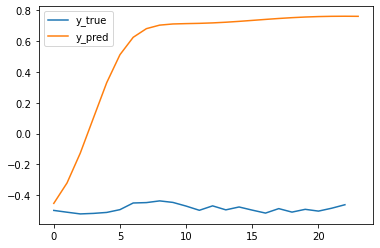

In [89]:
print(y.shape)
forecasts = np.array(forecasts)
forecasts = forecasts.reshape(forecast_window_len)
pyplot.plot(y[seq_len+1:seq_len+24], label='y_true')
pyplot.plot(forecasts, label='y_pred')
pyplot.legend()
pyplot.show()